# Exercise 4
ccdp method doesn't remove top 50 in overscan y-direction (size 2102, 500) \
pynot method removes top 50 in overscan y-direction (size 2052, 500) \

## DON'T USE NUMPY FOR MEAN, MEDIAN OR STD!!

In [71]:
import dfitspy
from matplotlib import pyplot as plt
import numpy as np
from astropy import units as u
from astropy.io import fits
from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy.table import Table
import astropy.stats
import pynot
from pynot.wavecal import rectify
from pynot.calibs import combine_bias_frames
from pynot.scired import auto_fit_background

import ccdproc as ccdp
from pathlib import Path
from ccdproc import ImageFileCollection
import os
import shutil

import scipy

from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile

In [2]:
os.listdir('DATA/BIAS/')

['ALAe230436.fits',
 'ALAe230441.fits',
 '.DS_Store',
 'ALAe230440.fits',
 'ALAe230437.fits',
 'biasliste1',
 'combined_bias.fit',
 'ALAe230444.fits',
 'ALAe230434.fits',
 'ALAe230438.fits',
 'ALAe230443.fits',
 'ALAe230442.fits',
 'MASTER_BIAS.fits',
 'ALAe230439.fits',
 'biaslist',
 'ALAe230435.fits']

In [3]:
bias_images = [m for m in os.listdir('DATA/BIAS/') if m.endswith('.fits')]
bias_images.remove('MASTER_BIAS.fits')
print(bias_images)

['ALAe230436.fits', 'ALAe230441.fits', 'ALAe230440.fits', 'ALAe230437.fits', 'ALAe230444.fits', 'ALAe230434.fits', 'ALAe230438.fits', 'ALAe230443.fits', 'ALAe230442.fits', 'ALAe230439.fits', 'ALAe230435.fits']


In [4]:
os.chdir('DATA/BIAS/')

In [5]:
#combined_bias = ccdp.combine(bias_images, unit = u.electron,
#                             method='average',
#                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
#                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
#                             mem_limit=350e6
#                            )

#combined_bias.meta['combined'] = True

#combined_bias.write('combined_bias.fit', overwrite=True)

In [6]:
with open('biaslist') as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]
print(lines)


['ALAe230434.fits', 'ALAe230435.fits', 'ALAe230436.fits', 'ALAe230437.fits', 'ALAe230438.fits', 'ALAe230439.fits', 'ALAe230440.fits', 'ALAe230441.fits', 'ALAe230442.fits', 'ALAe230443.fits', 'ALAe230444.fits']


In [7]:
biascombine=combine_bias_frames(lines, output='MASTER_BIAS.fits',overwrite=True)

In [8]:
print(fits.info('MASTER_BIAS.fits'))
print(fits.info('ALAe230434.fits'))

Filename: MASTER_BIAS.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  im1           1 PrimaryHDU     185   (500, 2052)   float64   
None
Filename: ALAe230434.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     152   ()      
  1  im1           1 ImageHDU        37   (500, 2102)   int32 (rescales to uint32)   
None


In [9]:
os.chdir('../../')

In [10]:
dataM, headerM = fits.getdata('DATA/BIAS/MASTER_BIAS.fits', header = True, dtype = int)
dataC, headerC = fits.getdata('DATA/BIAS/combined_bias.fit', header = True, dtype = int)

meanM, medianM, stdM = astropy.stats.sigma_clipped_stats(dataM, sigma = 3.0)
print('Data for Master Bias:','\n','Mean: ', meanM, '\n', 'Median: ', medianM, '\n', 'std: ', stdM)

Data for Master Bias: 
 Mean:  10364.531473829342 
 Median:  10363.09090909091 
 std:  22.07477132535593


In [11]:
meantot = []
mediantot = []
stdtot = []

for i in range(len(lines)):
    data, header = fits.getdata('DATA/BIAS/'+lines[i], header = True)
    mean, median, std = astropy.stats.sigma_clipped_stats(data, sigma = 3.0)
    meantot.append(mean)
    mediantot.append(median)
    stdtot.append(std)
    print('Data for',lines[i],':','\n','Mean: ', mean, '\n', 'Median: ', median, '\n', 'std: ', std )
print(np.mean(meantot), np.mean(mediantot), np.mean(stdtot))

Data for ALAe230434.fits : 
 Mean:  10365.079842237868 
 Median:  10364.0 
 std:  32.3639872358896
Data for ALAe230435.fits : 
 Mean:  10363.61389242455 
 Median:  10363.0 
 std:  32.37112586407901
Data for ALAe230436.fits : 
 Mean:  10362.80928972979 
 Median:  10362.0 
 std:  32.590335424386126
Data for ALAe230437.fits : 
 Mean:  10363.370103391822 
 Median:  10363.0 
 std:  32.78627393588143
Data for ALAe230438.fits : 
 Mean:  10363.028754933035 
 Median:  10362.0 
 std:  32.643049476987564
Data for ALAe230439.fits : 
 Mean:  10365.020619783232 
 Median:  10364.0 
 std:  32.64317803630448
Data for ALAe230440.fits : 
 Mean:  10365.423240697033 
 Median:  10365.0 
 std:  32.37699200837398
Data for ALAe230441.fits : 
 Mean:  10364.71499412955 
 Median:  10364.0 
 std:  32.527628784743456
Data for ALAe230442.fits : 
 Mean:  10366.410247384567 
 Median:  10366.0 
 std:  32.80911236481043
Data for ALAe230443.fits : 
 Mean:  10366.885833375942 
 Median:  10366.0 
 std:  32.64094597526961
D

In [12]:
flat_images = [m for m in os.listdir('DATA/') if m.endswith('.fits')]
flat_images.remove('COMB_FLAT.fits')
flat_images.remove('NORM_FLAT.fits')
flat_images.remove('COMBINED_FLAT.fits')
print(flat_images)

['ALAe230154.fits', 'ALAe230355.fits', 'ALAe230354.fits', 'ALAe230339.fits', 'ALAe230353.fits', 'ALAe230349.fits', 'ALAe230352.fits', 'ALAe230153.fits', 'ALAe230351.fits', 'ALAe230350.fits', 'ALAe230356.fits', 'ALAe230340.fits']


In [13]:
listfiles = dfitspy.get_files(flat_images, 'DATA/')
listkeys = ['CLAMP3','CLAMPNM3']

listbias = dfitspy.dfitsort(listfiles, listkeys, grepping = ['1'])

dfitspy.dfitsort_view(listbias)
blist = np.array(list(listbias.items()))
fnames = []

for i in range(5):
    fnames.append(blist[i,0])

print(fnames)


   filename    	CLAMP3	CLAMPNM3
---------------	------	--------
ALAe230353.fits	  1   	Halogen 
ALAe230349.fits	  1   	Halogen 
ALAe230352.fits	  1   	Halogen 
ALAe230351.fits	  1   	Halogen 
ALAe230350.fits	  1   	Halogen 
['ALAe230353.fits', 'ALAe230349.fits', 'ALAe230352.fits', 'ALAe230351.fits', 'ALAe230350.fits']


In [14]:
listfileshene = dfitspy.get_files(flat_images, 'DATA/')
listkeyshene = ['CLAMP1','CLAMPNM1', 'CLAMP2', 'CLAMPNM2']

listbiashene = dfitspy.dfitsort(listfileshene, listkeyshene, grepping = ['1'])

dfitspy.dfitsort_view(listbiashene)
blisthene = np.array(list(listbiashene.items()))
fnameshene = []

for i in range(len(blisthene[:,0])):
    fnameshene.append(blisthene[i,0])

print(fnameshene)
HeNe = fnames[0]
Ne = fnames[1]
He = fnames[2]

   filename    	CLAMP1	CLAMP2	CLAMPNM1	CLAMPNM2
---------------	------	------	--------	--------
ALAe230154.fits	  1   	  1   	   He   	   Ne   
ALAe230355.fits	  0   	  1   	   He   	   Ne   
ALAe230354.fits	  1   	  0   	   He   	   Ne   
['ALAe230154.fits', 'ALAe230355.fits', 'ALAe230354.fits']


In [15]:
os.chdir('DATA')

In [16]:
#combined_bias = ccdp.combine(fnames, unit = u.electron,
#                             method='average',
#                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
#                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
#                             mem_limit=350e6
#                            )

#combined_bias.meta['combined'] = True

#combined_bias.write('combined_flat.fit', overwrite=True)

In [17]:
#flatcombine=combine_bias_frames((fnames), output='COMB_FLAT.fits',overwrite=True, 
#                                mode = 'spec')

In [18]:
os.chdir('../')

In [19]:
#im_collection = ImageFileCollection('DATA/')
#im_collection.summary

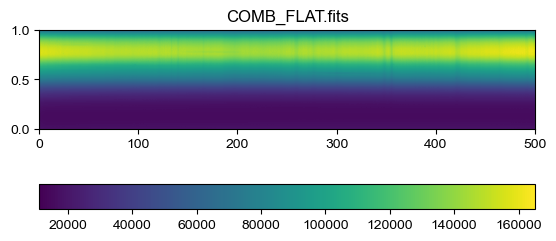

In [20]:
dataCF, headerCF = fits.getdata('DATA/COMB_FLAT.fits', header = True)

meanCF, medianCF, stdCF = astropy.stats.sigma_clipped_stats(dataM, sigma = 3.0)

plt.imshow(dataCF, extent=[0,100,0,1], aspect=100)
plt.colorbar(orientation = 'horizontal')
plt.title('COMB_FLAT.fits')
plt.imshow(dataCF, extent=[0,500,0,1], aspect=100)
plt.show()

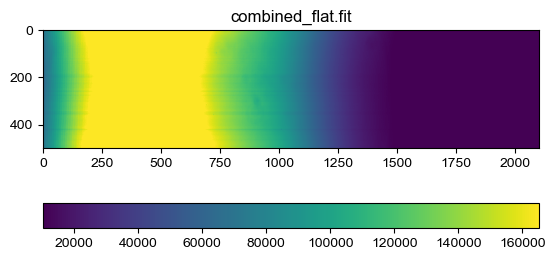

In [21]:
data, header = fits.getdata('DATA/combined_flat.fit', header = True)
data = data.T
mean, median, std = astropy.stats.sigma_clipped_stats(data, sigma = 3.0)

plt.imshow(data.T)
plt.colorbar(orientation = 'horizontal')
plt.title('combined_flat.fit')
plt.imshow(data, vmin=mean-std, vmax=mean+std)
plt.show()

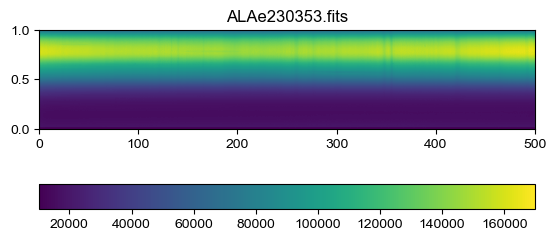

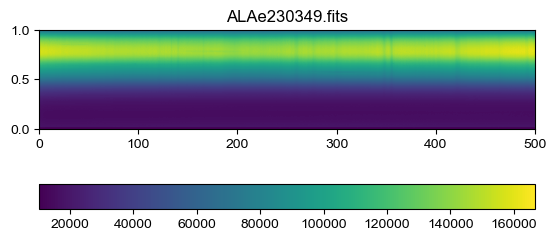

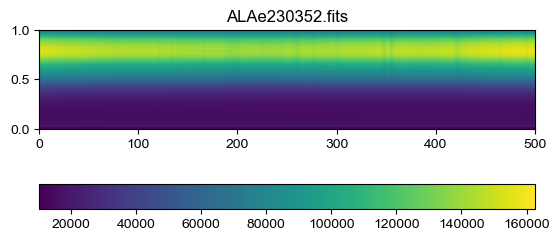

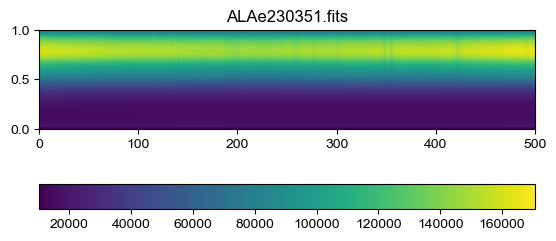

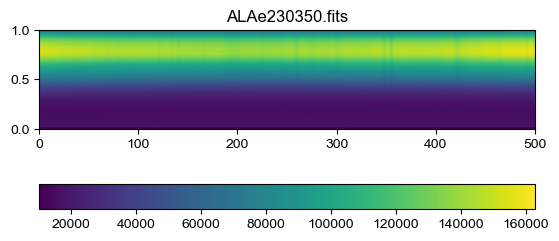

In [22]:
for i in range(len(fnames)):
    data, header = fits.getdata('DATA/'+fnames[i], header = True)

    mean, median, std = astropy.stats.sigma_clipped_stats(data, sigma = 3.0)
    plt.imshow(data, extent=[0,100,0,1], aspect=100)
    plt.colorbar(orientation = 'horizontal')
    plt.title(fnames[i])
    plt.imshow(data, extent=[0,500,0,1], aspect=100)

    plt.show()

In [23]:
os.listdir()

['SN_230340.fits',
 'GUI_attempt2',
 'Spec_GUI.ipynb',
 'GUI_attempt3',
 '.DS_Store',
 'Ne_Spec_Corr.fits',
 'ss_corrected.fits',
 'SN339_corr.fits',
 'PixTable2D.pdf',
 'He_Spec_Corr.fits',
 'SPEC_P1.ipynb',
 'STANDARD',
 'SN339_bcksub.fits',
 'gui_attempt1',
 'comb_arc.fits',
 'SN340_bcksub.fits',
 'comb_arcs.fits',
 'SS_bcksub.fits',
 'air_henear.dat',
 'HeNe_Spec_Corr.fits',
 'comb_arc_corr.fits',
 '.ipynb_checkpoints',
 'SN_230339.fits',
 'DATA',
 'ThAr_Spec_Corr.fits',
 'SN340_corr.fits',
 'SS_corr.fits']

In [24]:
os.chdir('DATA/')

In [25]:
mypath = os.getcwd()
print(mypath)

calibrated_path = Path(mypath)
flats = ccdp.ImageFileCollection(calibrated_path)
print(flats)

add_filters = {'IMAGETYP' : 'FLAT,LAMP' }
flatslist = flats.files_filtered(include_path = True, **add_filters)
flatslistnames = flats.files_filtered(include_path = False, **add_filters)

/Users/Nicolas/Documents/Kandidat i Fysik/Aktuelle Kurser/Astronomical Data Processing/Assignments/Spectroscopy/DATA
ImageFileCollection(location=PosixPath('/Users/Nicolas/Documents/Kandidat i Fysik/Aktuelle Kurser/Astronomical Data Processing/Assignments/Spectroscopy/DATA'))


In [26]:
flatcombine = pynot.calibs.combine_flat_frames(flatslistnames, output = 'COMBINED_FLAT.fits', mbias = 'MASTER_BIAS.fits',
                                 mode = 'spec', overwrite = True, dispaxis = 2)


In [27]:
pynot.calibs.normalize_spectral_flat('COMBINED_FLAT.fits', output = 'NORM_FLAT.fits', 
                                     order = 5, dispaxis = 2)

('NORM_FLAT.fits',
 '          - Input file: COMBINED_FLAT.fits\n          - Grism Name: al-gr4\n          - Slit Name: slit_1.0\n          - Automatic edge detection found 0 edges\n[WARNING] - Automatic edge detection failed. Using full frame!\n          - Median filtering flat frame along spectral axis to reduce noise\n          - Fitting each spatial row/column using Chebyshev polynomials combined with Savitzky--Golay filtering\n          - Polynomial order: 5\n          - Savitzky--Golay filter width: 51\n          - Standard deviation of 1D residuals: 0.01 ADUs\n          - Normalized data range: min=4.48e-01  max=1.17e+00  median=1.00e+00\n          - Saved graphic output for 1D model: specflat_1d_COMBINED_FLAT.pdf\n          - Saved graphic output for 2D model: specflat_2d_COMBINED_FLAT.pdf\n [OUTPUT] - Saving normalized MASTER FLAT: NORM_FLAT.fits\n')

In [28]:
os.chdir('../')

In [29]:
listf = dfitspy.get_files(flat_images, 'DATA/')
listk = ['OBJECT', 'IMAGETYP', 'CLAMP1','CLAMPNM1', 
         'CLAMP2', 'CLAMPNM2', 'CLAMP4', 'CLAMPNM4']
lists = dfitspy.dfitsort(listf, listk, grepping = None)
dfitspy.dfitsort_view(lists)

   filename    	CLAMP1	CLAMP2	CLAMP4	CLAMPNM1	CLAMPNM2	CLAMPNM4 	IMAGETYP 	        OBJECT         
---------------	------	------	------	--------	--------	---------	---------	-----------------------
ALAe230154.fits	  1   	  1   	  0   	   He   	   Ne   	ThAr Holl	WAVE,LAMP	         HeNe          
ALAe230355.fits	  0   	  1   	  0   	   He   	   Ne   	ThAr Holl	WAVE,LAMP	   Ne alfosc-calibs    
ALAe230354.fits	  1   	  0   	  0   	   He   	   Ne   	ThAr Holl	WAVE,LAMP	   He alfosc-calibs    
ALAe230339.fits	  0   	  0   	  0   	   He   	   Ne   	ThAr Holl	 OBJECT  	        2017eaw        
ALAe230353.fits	  0   	  0   	  0   	   He   	   Ne   	ThAr Holl	FLAT,LAMP	Halogen 5 alfosc-calibs
ALAe230349.fits	  0   	  0   	  0   	   He   	   Ne   	ThAr Holl	FLAT,LAMP	Halogen 1 alfosc-calibs
ALAe230352.fits	  0   	  0   	  0   	   He   	   Ne   	ThAr Holl	FLAT,LAMP	Halogen 4 alfosc-calibs
ALAe230153.fits	  0   	  0   	  0   	   He   	   Ne   	ThAr Holl	   STD   	       BD332642        
ALAe230351

In [30]:
listscifi = dfitspy.get_files(flat_images, 'DATA/')
listscikey = ['OBJECT', 'EXPTIME', 'IMAGETYP', 'CLAMP1','CLAMPNM1', 'CLAMP2', 'CLAMPNM2']
listsci = dfitspy.dfitsort(listscifi, listscikey, grepping = ['300.0'])
listsci2 = dfitspy.dfitsort(listscifi, listscikey, grepping = ['BD332642'])
dfitspy.dfitsort_view(listsci)
dfitspy.dfitsort_view(listsci2)

sciSN = np.array(list(listsci.items()))
sciStandard = np.array(list(listsci2.items()))
scisci = []
for i in range(2):
    scisci.append(sciSN[i,0])
    if i == 0:
        scisci.append(sciStandard[i,0])

scisci[1], scisci[2] = scisci[2], scisci[1] 
print(scisci)

   filename    	CLAMP1	CLAMP2	CLAMPNM1	CLAMPNM2	EXPTIME	IMAGETYP	OBJECT 
---------------	------	------	--------	--------	-------	--------	-------
ALAe230339.fits	  0   	  0   	   He   	   Ne   	 300.0 	 OBJECT 	2017eaw
ALAe230340.fits	  0   	  0   	   He   	   Ne   	 300.0 	 OBJECT 	2017eaw
   filename    	CLAMP1	CLAMP2	CLAMPNM1	CLAMPNM2	EXPTIME	IMAGETYP	 OBJECT 
---------------	------	------	--------	--------	-------	--------	--------
ALAe230153.fits	  0   	  0   	   He   	   Ne   	 50.0  	  STD   	BD332642
['ALAe230339.fits', 'ALAe230340.fits', 'ALAe230153.fits']


In [31]:
SN_230339 = pynot.scired.correct_raw_file(input_fname = 'DATA/' + scisci[0], output = 'SN_230339.fits',
                                       bias_fname = 'DATA/BIAS/MASTER_BIAS.fits',
                                       flat_fname = 'DATA/NORM_FLAT.fits')

SN_230340 = pynot.scired.correct_raw_file(input_fname = 'DATA/' + scisci[1], output = 'SN_230340.fits',
                                       bias_fname = 'DATA/BIAS/MASTER_BIAS.fits',
                                       flat_fname = 'DATA/NORM_FLAT.fits')

ss_corr = pynot.scired.correct_raw_file(input_fname = 'DATA/' + scisci[2], output = 'ss_corrected.fits',
                                       bias_fname = 'DATA/BIAS/MASTER_BIAS.fits',
                                       flat_fname = 'DATA/NORM_FLAT.fits')


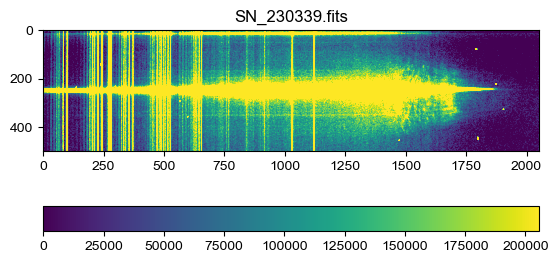

In [32]:
data, header = fits.getdata('SN_230339.fits', header = True)
data = data.T
mean, median, std = astropy.stats.sigma_clipped_stats(data, sigma = 3.0)

plt.imshow(data.T)
plt.colorbar(orientation = 'horizontal')
plt.title('SN_230339.fits')
plt.imshow(data, vmin=mean-std, vmax=mean+std)
plt.show()

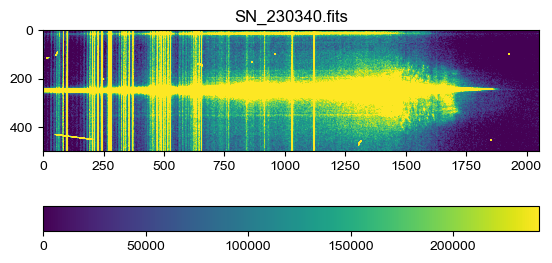

In [33]:
data, header = fits.getdata('SN_230340.fits', header = True)
data = data.T
mean, median, std = astropy.stats.sigma_clipped_stats(data, sigma = 3.0)

plt.imshow(data.T)
plt.colorbar(orientation = 'horizontal')
plt.title('SN_230340.fits')
plt.imshow(data, vmin=mean-std, vmax=mean+std)
plt.show()

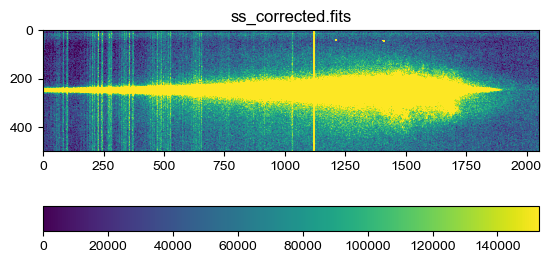

In [34]:
data, header = fits.getdata('ss_corrected.fits', header = True)
data = data.T
mean, median, std = astropy.stats.sigma_clipped_stats(data, sigma = 3.0)

plt.imshow(data.T)
plt.colorbar(orientation = 'horizontal')
plt.title('ss_corrected.fits')
plt.imshow(data, vmin=mean-std, vmax=mean+std)
plt.show()

In [35]:
HeSpec = pynot.scired.correct_raw_file(input_fname = 'DATA/ALAe230354.fits', 
                                       output = 'He_Spec_Corr.fits',
                                       bias_fname = 'DATA/BIAS/MASTER_BIAS.fits',
                                       flat_fname = 'DATA/NORM_FLAT.fits')

NeSpec = pynot.scired.correct_raw_file(input_fname = 'DATA/ALAe230355.fits', 
                                       output = 'Ne_Spec_Corr.fits',
                                       bias_fname = 'DATA/BIAS/MASTER_BIAS.fits',
                                       flat_fname = 'DATA/NORM_FLAT.fits')

ThArSpec = pynot.scired.correct_raw_file(input_fname = 'DATA/ALAe230356.fits', 
                                        output = 'ThAr_Spec_Corr.fits',
                                        bias_fname = 'DATA/BIAS/MASTER_BIAS.fits',
                                        flat_fname = 'DATA/NORM_FLAT.fits')

HeNeSpec = pynot.scired.correct_raw_file(input_fname = 'DATA/ALAe230154.fits', 
                                        output = 'HeNe_Spec_Corr.fits',
                                        bias_fname = 'DATA/BIAS/MASTER_BIAS.fits',
                                        flat_fname = 'DATA/NORM_FLAT.fits')

In [36]:
arc_lamp = ['DATA/ALAe230354.fits','DATA/ALAe230355.fits',
            'DATA/ALAe230356.fits', 'DATA/ALAe230154.fits']

combined_arc = ccdp.combine(arc_lamp, unit = u.electron,
                             
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

combined_arc.meta['combined'] = True

combined_arc.write('comb_arc.fits', overwrite=True)

#combined_arc = ccdp.combine(arc_lamp, output_file = 'comb_arcs.fits', 
#                            overwrite=True, unit = u.electron)
arc_corr = pynot.scired.correct_raw_file(input_fname = 'comb_arc.fits', 
                                        output = 'comb_arc_corr.fits',
                                        bias_fname = 'DATA/BIAS/MASTER_BIAS.fits',
                                        flat_fname = 'DATA/NORM_FLAT.fits')

INFO:astropy:first HDU with data is extension 1.
INFO:astropy:using the unit electron passed to the FITS reader instead of the unit count in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-AVG to 57897.250453 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 57897.250453 from DATE-AVG'.
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'.
INFO:astropy:first HDU with data is extension 1.
INFO:astropy:using the unit electron passed to the FITS reader instead of the unit count in the FITS file.
INFO:astropy:first HDU with data is extension 1.
INFO:astropy:using the unit electron passed to the FITS reader instead of the unit count in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is depr

INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: using the unit electron passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: using the unit electron passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: using the unit electron passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


Set MJD-AVG to 57897.250735 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 57897.250735 from DATE-AVG'.
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'.
INFO:astropy:first HDU with data is extension 1.
INFO:astropy:using the unit electron passed to the FITS reader instead of the unit count in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-AVG to 57897.251279 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 57897.251279 from DATE-AVG'.
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'.
INFO:astropy:first HDU with data is extension 1.
INFO:astropy:using the unit electron pass

INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: using the unit electron passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: using the unit electron passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


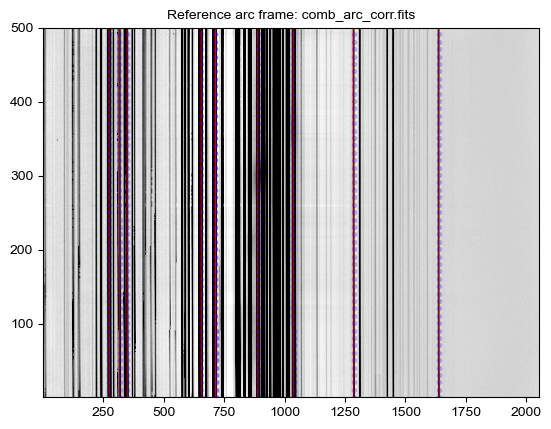

In [37]:
SN339_corr = pynot.wavecal.rectify('SN_230339.fits', 'comb_arc_corr.fits', 
                     'GUI_attempt3', output = 'SN339_corr.fits')

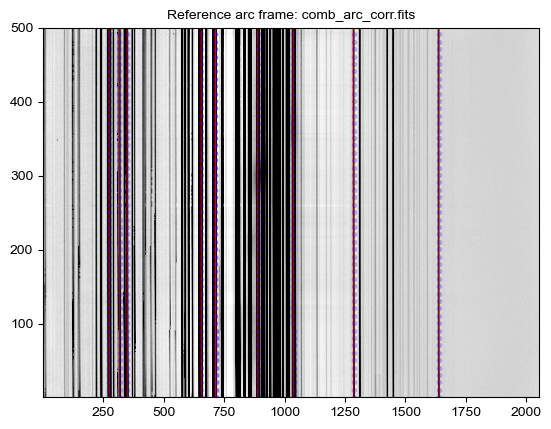

In [38]:
SN340_corr = pynot.wavecal.rectify('SN_230340.fits', 'comb_arc_corr.fits',
                    'GUI_attempt3', output = 'SN340_corr.fits')

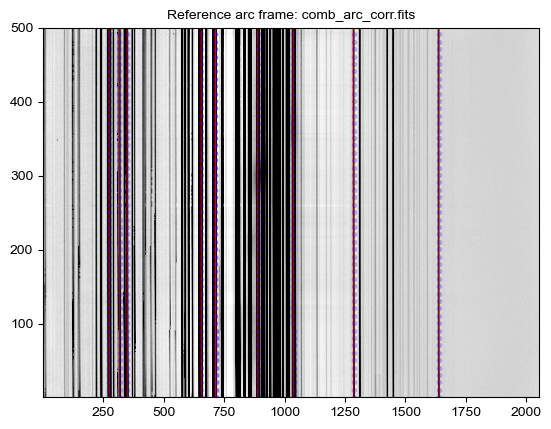

In [39]:
Stanstar_corr = pynot.wavecal.rectify('ss_corrected.fits', 'comb_arc_corr.fits',
                       'GUI_attempt3', output = 'SS_corr.fits')

In [41]:
data339, header339 = fits.getdata('SN339_corr.fits', header = True)
mean339, median339, std339 = astropy.stats.sigma_clipped_stats(data339, sigma = 3.0)

data340, header340 = fits.getdata('SN340_corr.fits', header = True)
mean340, median340, std340 = astropy.stats.sigma_clipped_stats(data340, sigma = 3.0)

datass, headerss = fits.getdata('SS_corr.fits', header = True)
meanss, medianss, stdss = astropy.stats.sigma_clipped_stats(datass, sigma = 3.0)

row339 = data339[200,:]
row340 = data340[200,:]
rowss = datass[200,:]

start = 2959.846878038218
n = 3.160397288136664
    
index_max1 = np.argmax(row339)
index_max2 = np.argmax(row340)
index_max3 = np.argmax(rowss)

x1 = range(len(row339))
x2 = range(len(row340))
x3 = range(len(rowss))

initial_val1 = [np.max(row339), x1[index_max1], 5, np.min(row339)]
initial_val2 = [np.max(row340), x2[index_max2], 5, np.min(row340)]
initial_val3 = [np.max(rowss), x3[index_max3], 5, np.min(rowss)]

def gaussian(x, amp, cen, wid, C):
    return amp*np.exp(- ((x - cen) ** 2) / (2*wid**2 )) + C

popt1, pcov1 = scipy.optimize.curve_fit(gaussian, x1, row339, p0 = [initial_val1])
popt2, pcov2 = scipy.optimize.curve_fit(gaussian, x2, row340, p0 = [initial_val2])
popt3, pcov3 = scipy.optimize.curve_fit(gaussian, x3, rowss, p0 = [initial_val3])
print(np.shape(rowss))


(2052,)


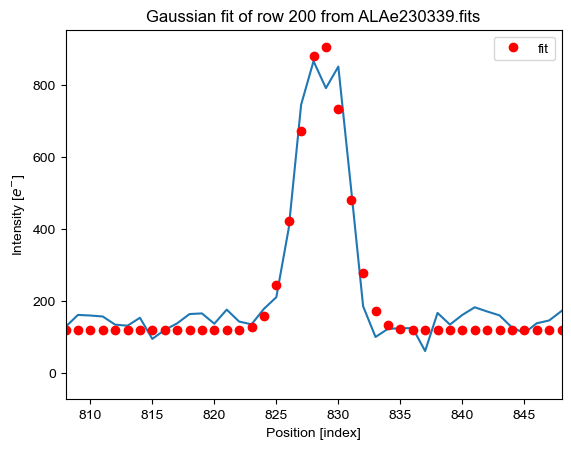

In [65]:
plt.plot(x1,row339)
plt.plot(x1, gaussian(x1, *popt1), 'ro', label = 'fit')
plt.legend()
plt.title('Gaussian fit of row 200 from ALAe230339.fits')
plt.xlabel('Position [index]')
plt.ylabel(r'Intensity [$e^{-}$]')
plt.xlim(x1[index_max1]-20, x1[index_max1]+20)
plt.show()

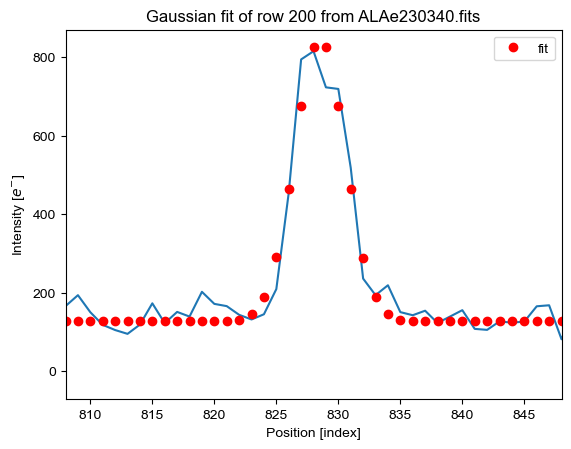

In [66]:
plt.plot(x2,row340)
plt.plot(x2, gaussian(x2, *popt2), 'ro', label = 'fit')
plt.legend()
plt.title('Gaussian fit of row 200 from ALAe230340.fits')
plt.xlabel('Position [index]')
plt.ylabel(r'Intensity [$e^{-}$]')
plt.xlim(x2[index_max2]-20, x2[index_max2]+20)
plt.show()

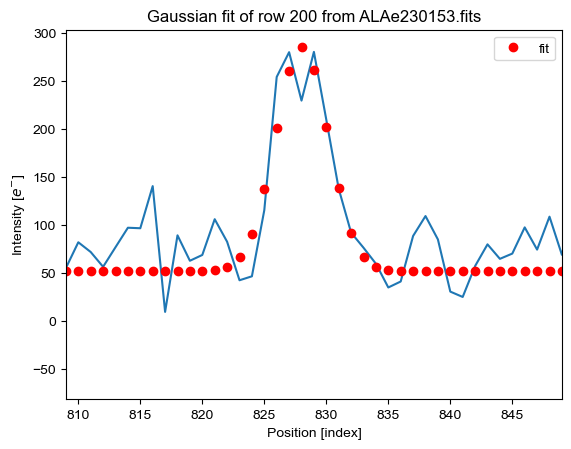

In [67]:
plt.plot(x3,rowss)
plt.plot(x3, gaussian(x3, *popt3), 'ro', label = 'fit')
plt.legend()
plt.title('Gaussian fit of row 200 from ALAe230153.fits')
plt.xlabel('Position [index]')
plt.ylabel(r'Intensity [$e^{-}$]')
plt.xlim(x3[index_max3]-20, x3[index_max3]+20)
plt.show()

In [59]:
print('FWHM for SN339: ', popt1[2], 'pixels')
print('FWHM for SN340: ', popt2[2], 'pixels')
print('FWHM for Standard: ', popt3[2], 'pixels')

print('Seeing for SN339: ', popt1[2]*0.21, 'arcsec')
print('Seeing for SN340: ', popt2[2]*0.21, 'arcsec')
print('Seeing for Standard: ', popt3[2]*0.21, 'arcsec')

FWHM for SN339:  1.8755137905099493 pixels
FWHM for SN340:  2.0283170676169044 pixels
FWHM for Standard:  2.1200375565496046 pixels
Seeing for SN339:  0.3938578960070893 arcsec
Seeing for SN340:  0.4259465841995499 arcsec
Seeing for Standard:  0.44520788687541696 arcsec


In [55]:
print(np.argmax(row339)*n+start, (1-(np.argmax(row339)*n+start)/5577)*100)
print(np.argmax(row340)*n+start, (1-(np.argmax(row340)*n+start)/5577)*100)
print(np.argmax(rowss)*n+start, (1-(np.argmax(rowss)*n+start)/5577)*100)

5576.655832615375 0.006171192121651181
5576.655832615375 0.006171192121651181
5579.816229903512 -0.05049721899788029


In [47]:
auto_fit_background('SN339_corr.fits', output_fname = 'SN339_bcksub.fits')
auto_fit_background('SN340_corr.fits', output_fname = 'SN340_bcksub.fits')
auto_fit_background('SS_corr.fits', output_fname = 'SS_bcksub.fits')

'          - Loaded input image: SS_corr.fits\n          - Fitting background along the spatial axis with polynomium of order: 3\n          - Automatic masking of outlying pixels and object trace\n          - Number of pixels rejected: 21\n [OUTPUT] - Saving background subtracted image: SS_bcksub.fits\n'

In [48]:
print(mean339, median339, std339)
print(mean340, median340, std340)
print(meanss, medianss, stdss)

datasub1, headersub1 = fits.getdata('SN339_bcksub.fits', header = True)
mean339, median339, std339 = astropy.stats.sigma_clipped_stats(datasub1, sigma = 3.0)

datasub2 , headersub2 = fits.getdata('SN340_bcksub.fits', header = True)
mean340, median340, std340 = astropy.stats.sigma_clipped_stats(datasub2, sigma = 3.0)

datasub3, headersub3 = fits.getdata('SS_bcksub.fits', header = True)
meanss, medianss, stdss = astropy.stats.sigma_clipped_stats(datasub3, sigma = 3.0)

print(mean339, median339, std339)
print(mean340, median340, std340)
print(meanss, medianss, stdss)

104.19821739110986 98.61984538183262 52.540393021601496
110.28353456724425 105.08621358885532 54.884022485687964
36.214469356285235 33.07898979086167 32.703245122957156
-5.270393127135412 -6.601507440105145 34.997067389377506
-35.42525647693017 -32.97565941299827 66.0012238879214
-3.994161711200497 -4.579324342751784 29.694512870804843


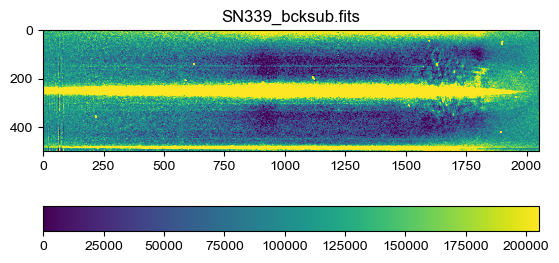

In [49]:
plt.imshow(np.flip(datasub1, axis = None))
plt.colorbar(orientation = 'horizontal')
plt.title('SN339_bcksub.fits')
plt.imshow(np.flip(datasub1, axis = None), vmin=mean339-std339, vmax=mean339+std339)
plt.show()

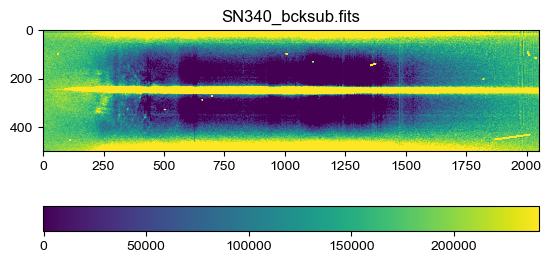

In [50]:
plt.imshow(datasub2)
plt.colorbar(orientation = 'horizontal')
plt.title('SN340_bcksub.fits')
plt.imshow(datasub2, vmin=mean340-std340, vmax=mean340+std340)
plt.show()

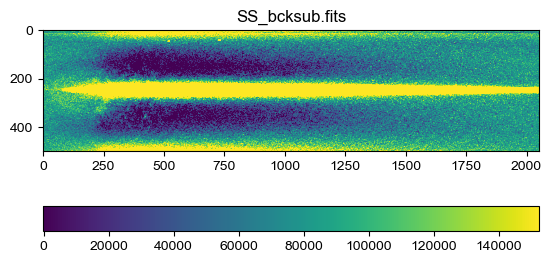

In [51]:
plt.imshow(datasub3)
plt.colorbar(orientation = 'horizontal')
plt.title('SS_bcksub.fits')
plt.imshow(datasub3, vmin=meanss-stdss, vmax=meanss+stdss)
plt.show()

In [68]:
hdu = fits.open('SN339_corr_extract_moffat.fits')
hdu.info()

Filename: SN339_corr_extract_moffat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  DATA          1 BinTableHDU    201   2052R x 5C   [D, D, D, L, D]   


In [74]:
evt_data = Table(hdu[1].data)

wavelength = evt_data['WAVE']
snspec = evt_data['FLUX']
sn_err = evt_data['ERR']